In [39]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
from scipy import stats
import scipy.stats as ss
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)

# To ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Module 1: Data Prep

In [2]:
#load data function
def load_data(train, test, Id):
    train = pd.read_csv(train)
    test = pd.read_csv(test)

# Save the 'Id' column
    train_ID = train[Id]
    test_ID = test[Id]

# Now drop the  'Id' column as it's redundant for modeling
    train.drop(Id, axis = 1, inplace = True)
    test.drop(Id, axis = 1, inplace = True)
    return train,test,test_ID


In [3]:
train,test,test_ID = load_data('train.csv','test.csv','Id')
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


### 1.1 Remove outliers from target
Drop rows from the train data where the corresponding target value is an outlier

In [4]:
#reject outliers from target if the number falls outside the 90th percentile
def reject_outliers(target):
    rowindx = list()
    prcntl = np.percentile(train[target], 90)
    for indx in range(0,len(train[target])):
        if train.loc[indx,target] > prcntl:
            rowindx.append(indx)
    train.drop(labels = rowindx, axis = 0,inplace = True)

In [5]:
target = 'SalePrice'

In [6]:
reject_outliers(target)

In [7]:
train.shape

(1315, 80)

### 1.2 treat missing values in test and train data
Fill missing values in numeric cols with the mean and missing values in the non numeric cols with the mode

In [9]:
#First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train[target]

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop([target], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2774, 79)


In [10]:
#start with getting the names numeric columns
numeric_cols = all_data.select_dtypes(include = [np.number]).columns.tolist()

In [11]:
#fill na with mean of columns
for col in numeric_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [13]:
#get names of non numeric columns
non_numeric_cols = all_data.select_dtypes(exclude = [np.number]).columns.tolist()

In [14]:
#fill na with mode of columns
for col in non_numeric_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

### 1.3 Treat missing values in Target
Fill missing target values with mean

In [15]:
y_train = y_train.fillna(y_train.mean())

# Module 2: Feature Engineering 

### 2.1 Enumerate Categorical Columns
Categorical columns will be enumerated by giving categories numbers corresponding to their frequency rank.

In [16]:
allmaps = list()

In [17]:
#enumerate columns
for col in non_numeric_cols:
    mydict = {}
    #construct dictionary to use for map
    keys,values = np.unique(all_data[col],return_counts = True)
    ranks = ss.rankdata(values)
    for x in range(0,len(ranks)):
        mydict[keys[x]] = ranks[x]
    allmaps.append(mydict)
    #use map
    all_data[col] = all_data[col].map(mydict)

### 2.2 Create Polynomials from highest correlated features(>0.4)

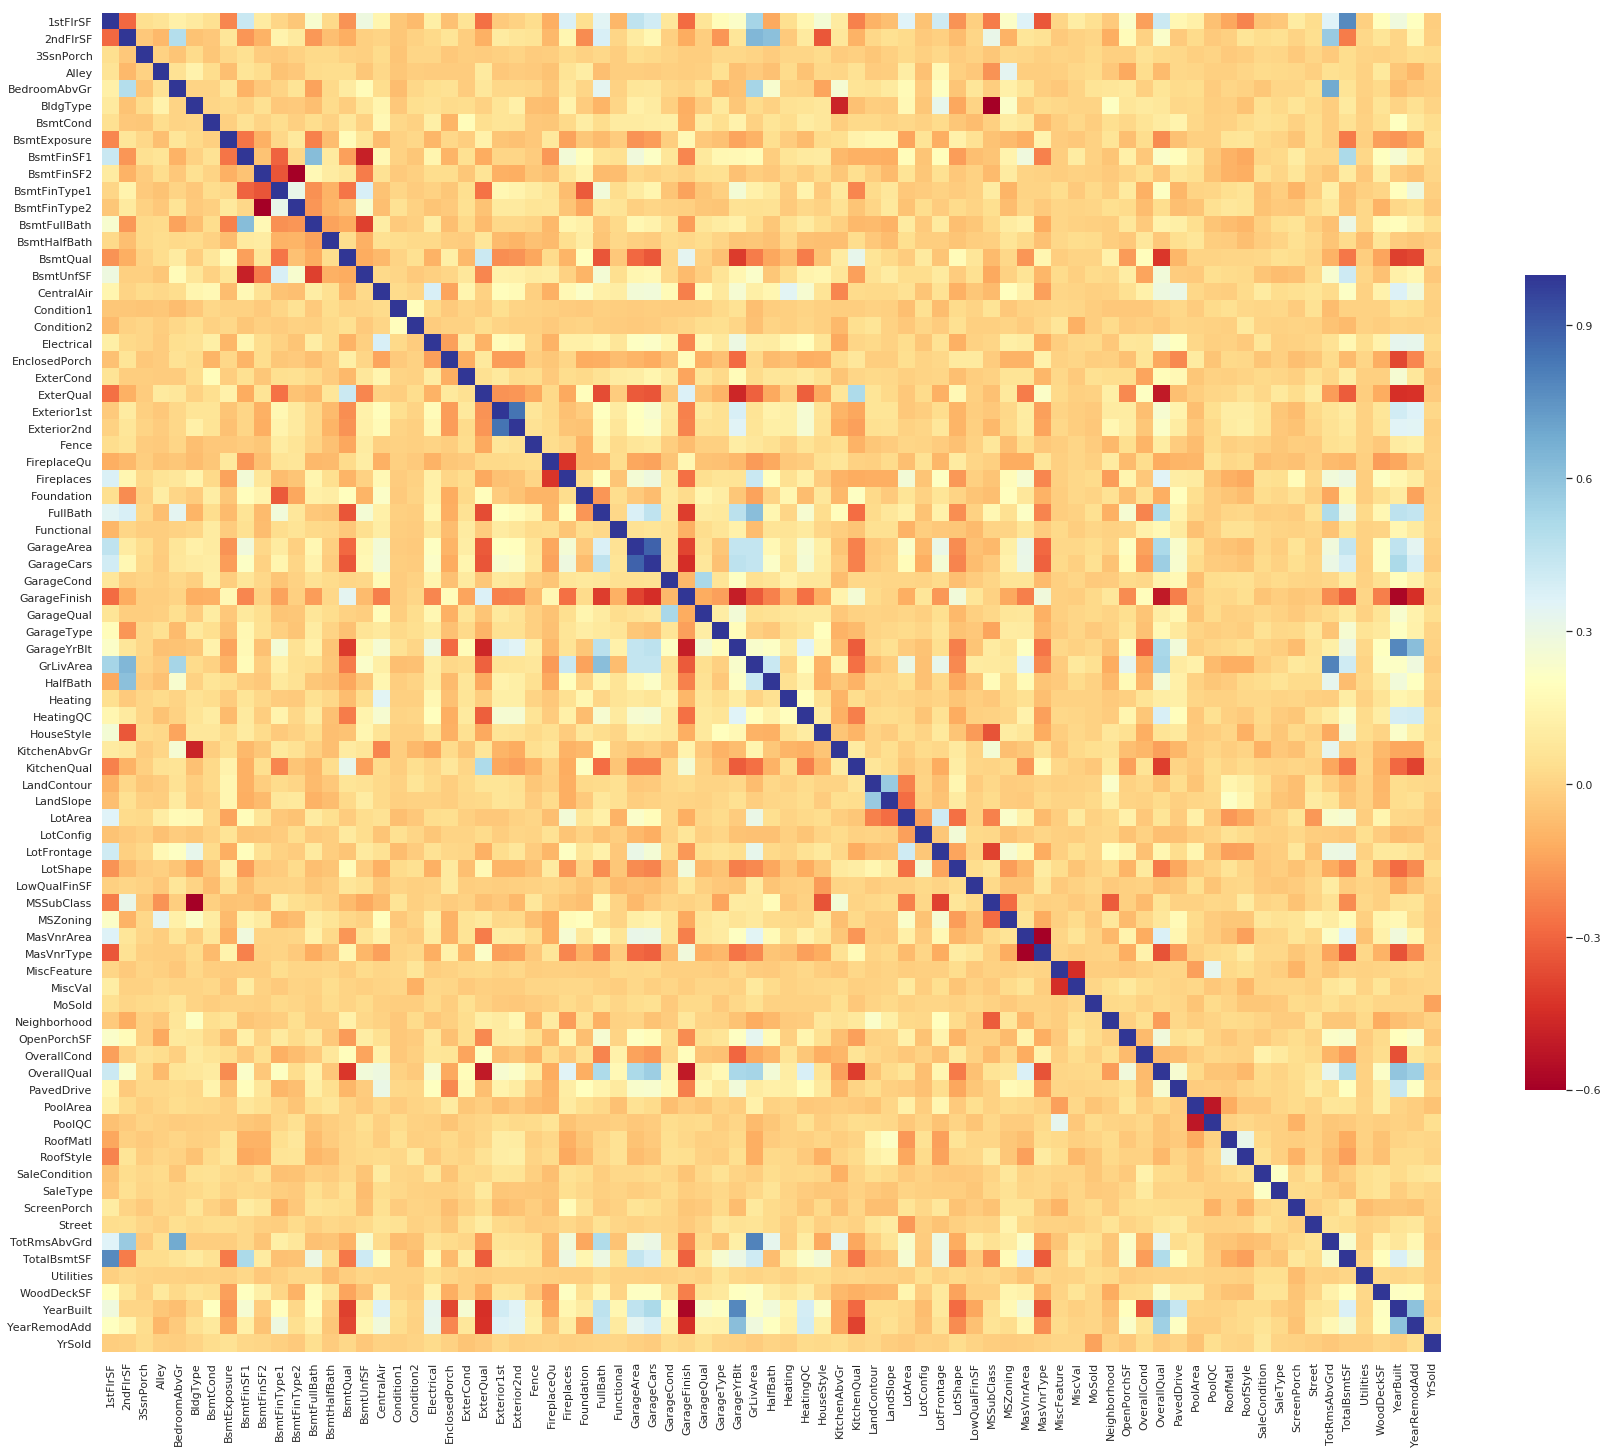

In [18]:
corr = all_data.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5})

In [19]:
high_cor_cols = list()

In [21]:
#get col names with high correlation
for col in numeric_cols:
    if (train[col].corr(y_train) > 0.4):
        high_cor_cols.append(col)

In [23]:
high_cor_cols

['1stFlrSF',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [24]:
#get quadratics/cubes/squareroots
for col in high_cor_cols:
    all_data[col+"-2"] = all_data[col] ** 2
    all_data[col+"-3"] = all_data[col] ** 3
    all_data[col+"-sq"] = np.sqrt(all_data[col])

In [25]:
all_data.shape

(2774, 115)

### 2.3 Treat Skews in Features
At this point we have only numeric columns throughout the whole DF

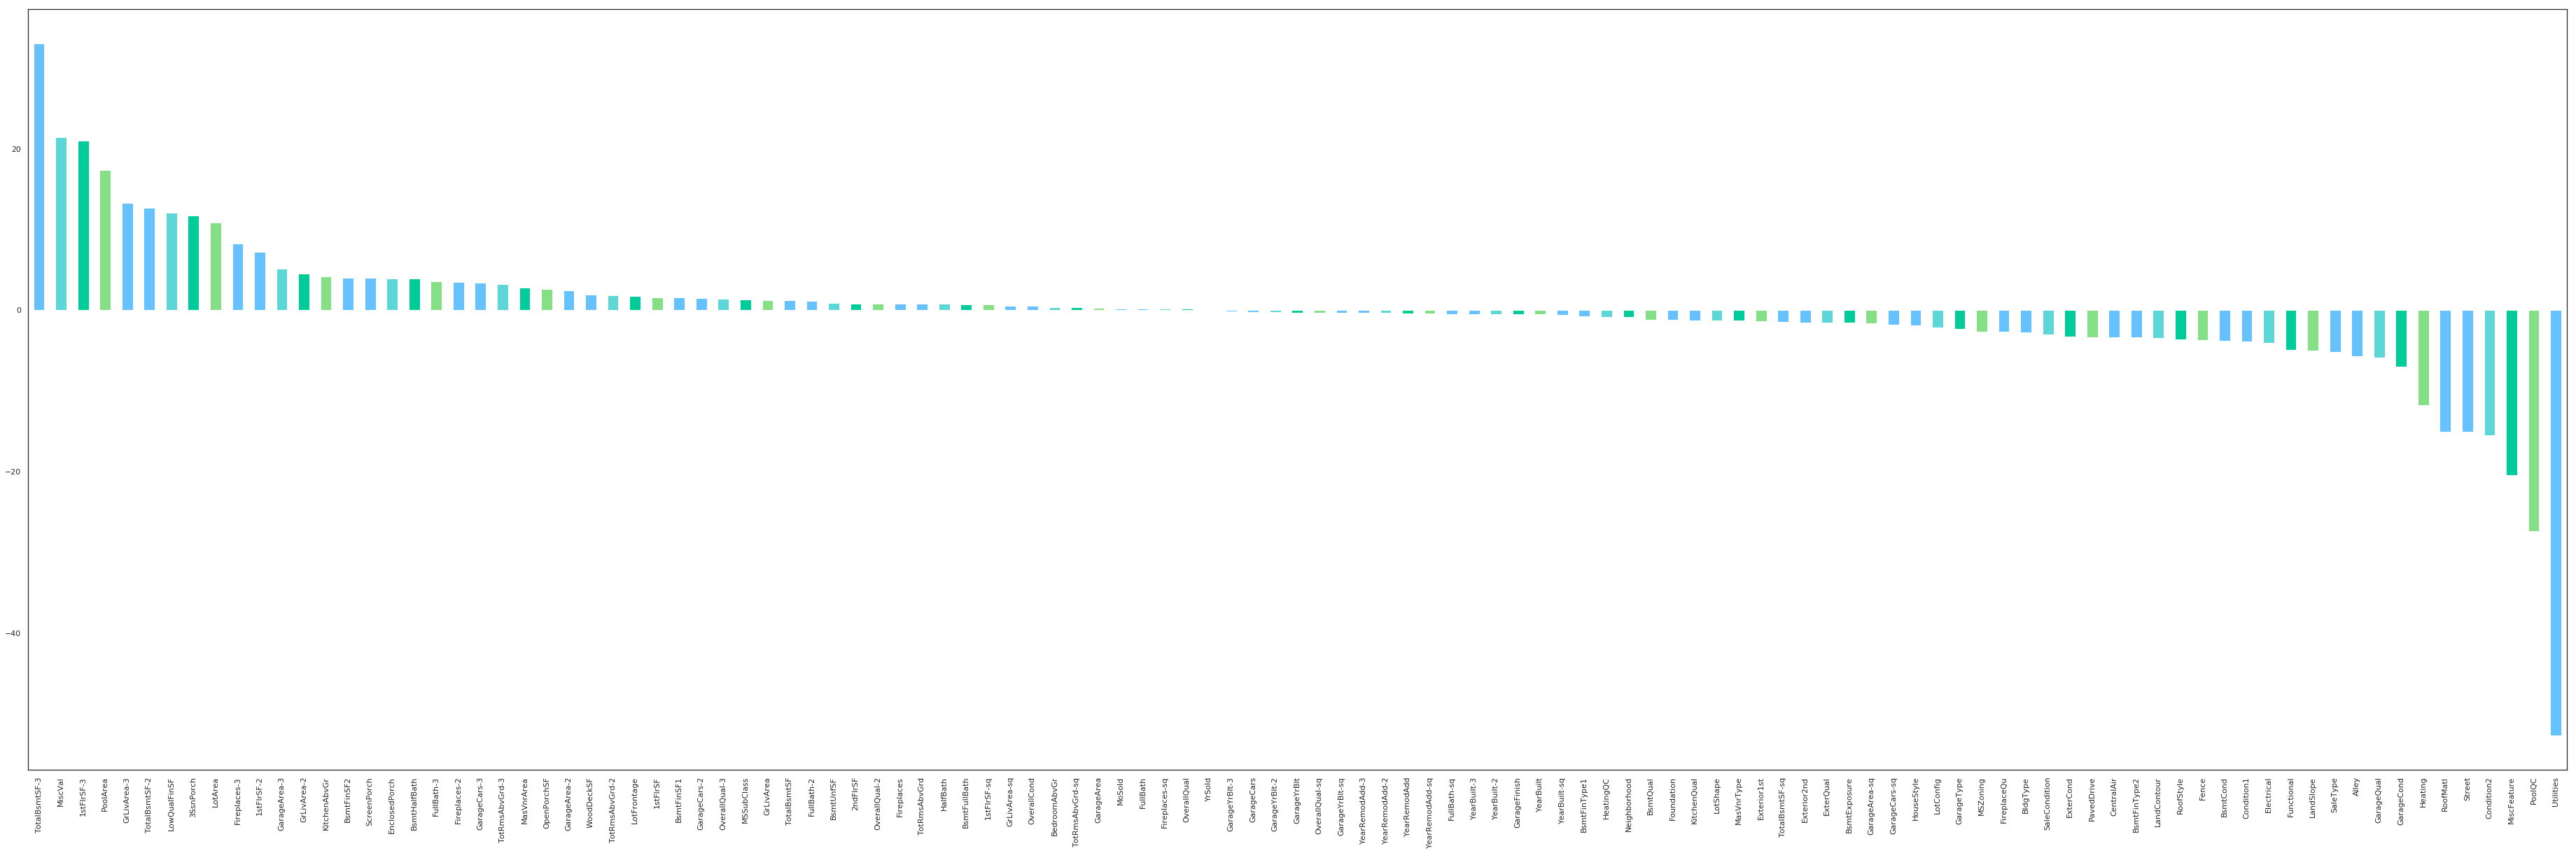

In [26]:
#show all skews 
plt.subplots(figsize =(65, 20))
all_data.skew().sort_values(ascending=False).plot(kind='bar')

Transform the features with abs skew values > 0.5 to follow more closely the normal distribution. Use Box-Cox.

In [27]:
skewed_feats = all_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

94 skewed numerical features have been Box-Cox transformed


### 2.4 Treat Skew in Target
**only treat skew if abs(skew) is greater than 0.5**

In [28]:
abs(y_train.skew())

0.3297991586468445

In [31]:
if abs(y_train.skew()) > 0.5:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
    y_train = np.log1p(y_train)

/home/harry/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


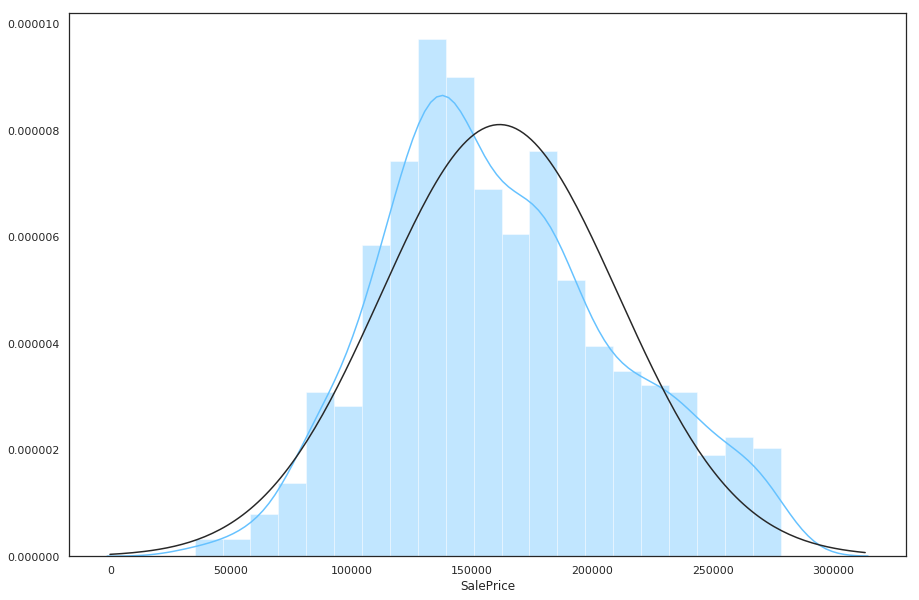

In [32]:
#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(y_train, fit=norm, label = "Skewness : %.2f"%(y_train.skew()))

In [35]:
y_train.skew()

0.3297991586468445

### 2.4 Drop columns with low variance (bottom 10%)

In [33]:
all_data.shape

(2774, 115)

In [29]:
#reject column if variance is in bottom 10%
index = range(0,(len(all_data.columns)))
columns = ['ColumnName','Var']
#var_data = {'Column':[np.array(all_data.columns)],'Var':[np.array(all_data.var())]}
var_cols = pd.DataFrame(index=index,columns=columns)
var_cols['Var'] = list(all_data.var())
var_cols['ColumnName'] = all_data.columns
prcntl = np.percentile(var_cols['Var'], 10)

In [30]:
low_var_cols = list()

In [31]:
#construct a list for low variance columns only
for indx in range(0,(len(var_cols))):
    if var_cols.loc[indx,'Var'] < prcntl:
        low_var_cols.append(var_cols.loc[indx,'ColumnName'])

In [32]:
low_var_cols

['Alley',
 'Condition2',
 'GarageCond',
 'GarageQual',
 'Heating',
 'MiscFeature',
 'PoolQC',
 'RoofMatl',
 'Street',
 'Utilities',
 'YearBuilt',
 'YearBuilt-sq']

In [33]:
#now drop the low var columns
all_data = all_data.drop(labels = low_var_cols, axis= 1)

In [34]:
all_data.shape

(2774, 103)

# Module 3: Modelling
### 3.1 Prep final data
Use XGBoosts feature importance to reduce number of features

In [35]:
# First, re-create the training and test datasets
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1315, 103)
(1459, 103)


In [36]:
y_train.shape

(1315,)

Text(0.5,1,'XGB feature importance')

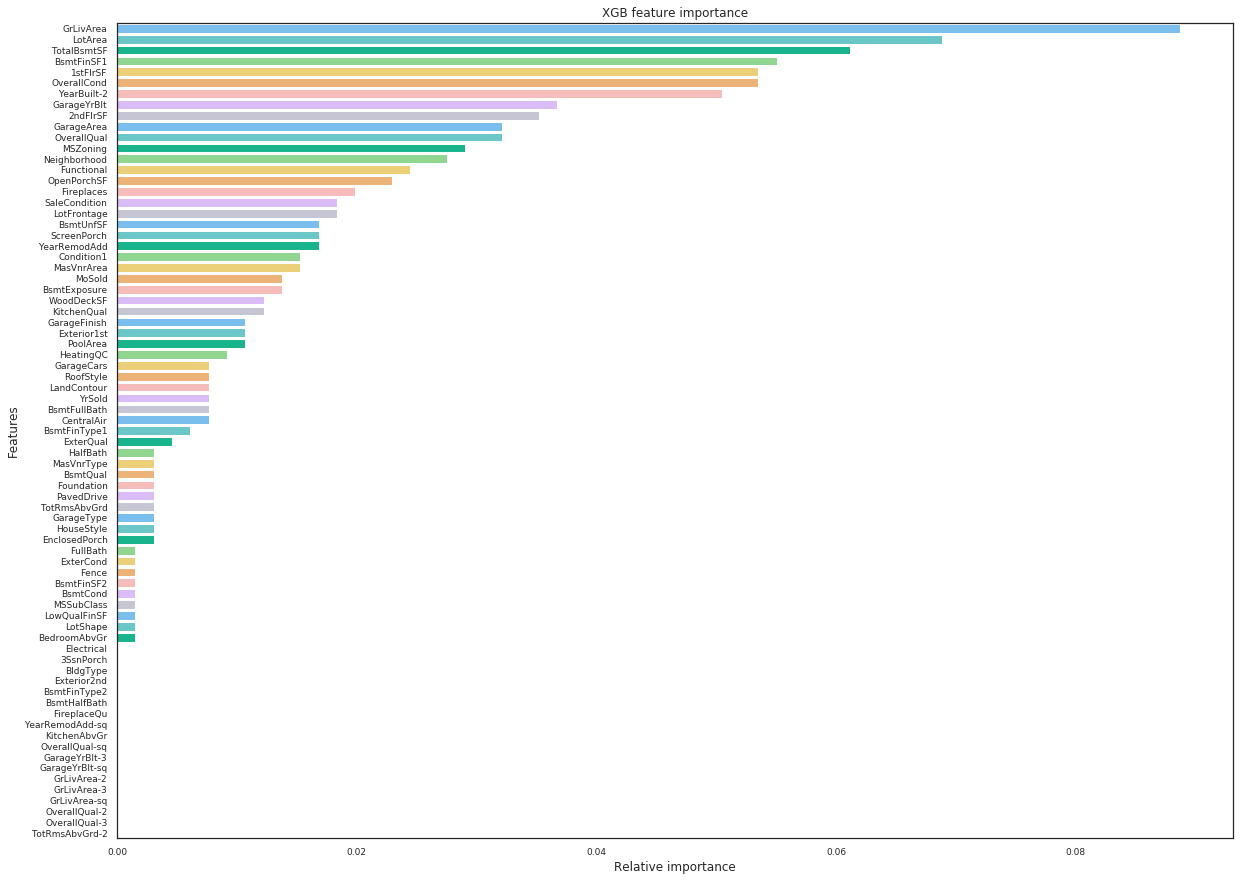

In [37]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance")

In [40]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1315, 30) 
X_test:  (1459, 30)


In [42]:
# Sample training data again for stacking
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)
print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (920, 30) 
X_test:  (395, 30) 
Y_train:  (920,) 
Y_test:  (395,)


In [43]:
print(X_train)

[[1.14732469e+01 1.14525405e+01 7.30463147e-01 ... 9.07241893e+00
  1.97600000e+03 5.82931574e+01]
 [1.16178569e+01 1.16178569e+01 1.82033410e+00 ... 8.01388370e+00
  1.99600000e+03 5.77855679e+01]
 [1.30845963e+01 0.00000000e+00 1.82033410e+00 ... 0.00000000e+00
  1.96300000e+03 5.81646509e+01]
 ...
 [1.17182285e+01 0.00000000e+00 1.82033410e+00 ... 0.00000000e+00
  1.97100000e+03 5.82438020e+01]
 [1.16990430e+01 0.00000000e+00 1.19431764e+00 ... 6.96946048e+00
  2.00800000e+03 5.81150667e+01]
 [1.20914047e+01 0.00000000e+00 1.82033410e+00 ... 0.00000000e+00
  1.95000000e+03 5.80355473e+01]]


### 3.2 Training
For this analysis use 8 different algorithms:

   **Kernel Ridge Regression,
    Elastic Net,
    Lasso,
    Gradient Boosting,
    Bayesian Ridge,
    Lasso Lars IC,
    Random Forest Regressor,
    XGBoost**

The method of measuring accuracy was chosen to be Root Mean Squared Error.

In [44]:
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",2498388.476,2138259.397
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",2476318.818,2248866.842
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",2242783.277,1939399.578
3,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",1870580.452,1665554.930
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",2249235.883,1937221.671
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",2255314.986,1933706.371
6,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",2171641.651,2034772.952
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",1894122.656,1655509.358


### 3.3 Optimisation
Use **GridSearchCV** to find the best combinations of parameters to produce the highest scoring models. To cut down computation time some hyperparameters were hard coded.

In [45]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'Optimised...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge Optimised...
2 ElasticNet Optimised...
3 Lasso Optimised...
4 GradientBoostingRegressor Optimised...
5 BayesianRidge Optimised...
6 LassoLarsIC Optimised...
7 RandomForestRegressor Optimised...
8 XGBRegressor Optimised...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",2258059.175,1939712.551
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",2242656.949,1938802.670
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",2242791.161,1939524.933
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",1833709.609,1619049.102
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",2249235.888,1937221.672
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",2255314.986,1933706.371
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",2094259.230,1941065.026
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",1779142.392,1640883.357


### 3.4 Stacking
Make predictions and construct stack

In [46]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

In [47]:
stacked_validation_train = stacked_validation_train.round(decimals=2)

In [48]:
stacked_validation_train['XGBoost'].apply(lambda x:round(x,2))

0      208789.09
1      119738.32
2      187716.94
3      230119.52
4      172627.28
5      206966.16
6      133513.11
7      192257.91
8      184867.72
9      156323.48
10     256878.59
11     245293.28
12     148327.73
13     161730.39
14     190936.27
15     150854.00
16     187554.91
17     123869.70
18     134051.03
19     155579.27
20     208824.44
21      91845.09
22     164873.44
23     244415.59
24     192166.16
25     128264.05
26     117109.72
27     128502.70
28     148369.53
29     144197.45
         ...    
365    118613.09
366    112879.75
367    174421.59
368    234594.14
369    140017.48
370    125964.84
371    166616.28
372    103009.45
373    113342.45
374    189182.05
375    160194.78
376    143455.27
377    121014.95
378    125577.66
379    200148.55
380    134666.52
381    191990.20
382    157132.25
383    163140.81
384    152937.36
385    107555.66
386    143181.61
387     69901.36
388    114341.45
389    193840.69
390    130216.71
391    174127.77
392     89758.

In [49]:
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,203776.28,204543.22,204607.34,209002.81,203956.08,201701.91,217498.93,208789.093750
1,124120.88,126193.37,126406.95,117585.59,124367.66,127306.51,108727.87,119738.320312
2,184620.49,179240.38,178811.12,188152.90,183325.41,176465.20,196666.72,187716.937500
3,218776.26,218493.09,218398.58,218802.52,219319.63,224758.51,220381.59,230119.515625
4,181799.72,182622.82,182671.76,181323.39,182202.07,181285.61,191992.35,172627.281250


In [50]:
stacked_test_train = stacked_test_train.apply(lambda x:round(x,2))
stacked_test_train['XGBoost'] = stacked_test_train['XGBoost'].apply(lambda x:round(x,2))

In [51]:
stacked_test_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,131594.86,131796.23,131800.61,124964.97,131862.13,131449.75,127841.22,127662.96
1,165695.50,165623.51,165694.83,148316.58,165014.27,164927.39,158167.90,154727.62
2,189114.69,190192.06,190219.42,188994.70,189842.87,189860.03,185647.01,195367.44
3,201799.46,202486.98,202495.12,202436.81,202276.31,202701.50,185934.72,195244.23
4,200049.55,199375.50,199344.81,198031.12,199619.66,195615.25,192866.70,190673.70


In [53]:
stacked_test_train

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,131594.86,131796.23,131800.61,124964.97,131862.13,131449.75,127841.22,127662.96
1,165695.50,165623.51,165694.83,148316.58,165014.27,164927.39,158167.90,154727.62
2,189114.69,190192.06,190219.42,188994.70,189842.87,189860.03,185647.01,195367.44
3,201799.46,202486.98,202495.12,202436.81,202276.31,202701.50,185934.72,195244.23
4,200049.55,199375.50,199344.81,198031.12,199619.66,195615.25,192866.70,190673.70
5,184262.98,185365.73,185498.56,176178.23,184241.67,182545.30,178415.29,180536.42
6,182667.00,182884.82,182862.41,172010.85,183021.30,180967.61,166657.03,179966.09
7,171924.68,173023.71,173071.36,161409.72,172484.88,173750.12,174231.28,160944.09
8,197485.94,198428.11,198518.77,192471.32,197637.92,195576.86,196311.57,188860.95
9,119138.24,119010.28,119018.08,120679.29,118799.26,119350.83,125043.60,125616.81


### 3.5 Ensemble
#### 3.51 Train and Optimise Bagging model then make predictions

In [54]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [55]:
def rfr_model(X, y,stacked_test_train):

# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='mean_squared_error')
    rfr.fit(X, y)
    pred = rfr.predict(stacked_test_train)

    return scores, pred

In [56]:
#first train the bagging model and get scores
bagging_scores,bagging_pred = rfr_model(stacked_validation_train,Y_test,stacked_test_train)
print(np.mean(np.sqrt(abs(bagging_scores))))#the scores are returned with signs flipped, refer: https://github.com/scikit-learn/scikit-learn/issues/2439

16655.112984955795


In [78]:
bagging_pred

array([129294.85628184, 159108.76932105, 190767.2710666 , ...,
       174247.28834618, 117588.45835977, 221952.05168845])

#### 3.52 Train and Optimise Boosting model then make predictions

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [62]:
GB = GradientBoostingRegressor()

In [63]:
def GB_model(X, y,stacked_test_train):
# Perform Grid-Search
    parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
     }
    gb = GradientBoostingRegressor()
    gsc = GridSearchCV(GB, parameters, cv=10, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    pred = gsc.predict(stacked_test_train)
    best_params = grid_result.best_params_

# Perform K-Fold CV
    scores = cross_val_score(gsc, X, y, cv=10, scoring='mean_squared_error')

    return scores,pred

In [64]:
GB_scores,GB_pred=GB_model(stacked_validation_train,Y_test,stacked_test_train)
print(GB_pred)

[126441.40453445 160726.97012103 194018.54951258 ... 168723.406925
 119649.97425115 221438.37382731]


In [81]:
np.mean(np.sqrt(list(abs(GB_scores))))

16878.448387452343

# Module 5: Make Submission Files

In [65]:
#check boosting predictions
GB_pred

array([126441.40453445, 160726.97012103, 194018.54951258, ...,
       168723.406925  , 119649.97425115, 221438.37382731])

In [60]:
#check bagging predictions
bagging_pred

array([127069.11599654, 160967.98366869, 193929.85846571, ...,
       174269.93536161, 119694.36103982, 221671.06528188])

In [85]:
#submission file 1, bagging only
bagging_sub = pd.DataFrame()
bagging_sub['Id'] = test_ID
bagging_sub['SalePrice'] = bagging_pred
bagging_sub.to_csv('bagging_submission.csv',index=False)

In [86]:
#submission file 2, boosting only
GB_sub = pd.DataFrame()
GB_sub['Id'] = test_ID
GB_sub['SalePrice'] = GB_pred
GB_sub.to_csv('boosting_submission.csv',index=False)

In [87]:
#submission file 3, boosting + bagging(50/50 split)
ensemble = bagging_pred*(0.5) + GB_pred*(0.5)
ensemble_df = pd.DataFrame()
ensemble_df['Id'] = test_ID
ensemble_df['SalePrice'] = ensemble
ensemble_df.to_csv('ensemble_submission.csv',index=False)